# Metropolis-Hastings algorithm.


## Markov Chains: quick recap

Let $X$ be a finite set. A ***Markov chain*** is defined by a matrix
$K(x, y)$ with $K(x, y) ≥ 0$, $∑_y K(x, y) = 1$ for each $x$. Thus each row is a probability measure so $K$ can direct a kind of random walk: from $x$, choose $y$ with probability $K(x, y)$; from $y$ choose $z$ with probability $K(y, z)$, and so on.

All of the Markov chains considered in this article have *stationary distributions* $π(x) > 0$, $∑_x π(x) = 1$ with $π$ satisfying:

$$\sum_x \pi(x)K(x,y) = \pi(y).$$

## Metropolis-Hastings algorithm

The Metropolis-Hastings algorithm is perhaps the most popular example of a [Markov chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) (MCMC) method in statistics. The basic problem that it solves is the sampling from some arbitrary probability distribution $p(x)$. In many cases, you know how the analytical representation of a probability $p(x)$, but you don’t know how to generate a random sample from this distribution, $x \sim p(x)$.

The idea behind this algorithm is to define a Markov chain over possible values, in such a way that the stationary distribution of the Markov chain is in fact $p(x)$. That is, what we’re going to do is use a Markov chain to generate a sequence of $x$ values, denoted $(x_0, x_1, \dots, x_n)$, in such a way that as $n → ∞$, we can guarantee that $x_n \sim p(x)$.

Here are the step-by-step instructions for the Metropolis-Hastings algorithm:

1. Start with an initial state, $x_0$, and a proposal distribution, $q(x'|x)$, that generates candidate states $x'$ from the current state $x$.

2. For each iteration $i$:
  - a. Generate a candidate state x' from the proposal distribution, $q(x'|x_i)$, the proposal distribution should be centered at the currently accepted sample.
  - b. Calculate the acceptance ratio, $\alpha = min(1, p(x')/p(x_i))$, where $p(x)$ is the target probability distribution. If $\alpha >= 1$, accept the candidate state $x'$, i.e., $x_{i+1} = x'$. If $\alpha < 1$, accept the candidate state $x'$ with probability alpha, i.e., generate a random number $u$ from a uniform distribution on $[0,1]$, and if $u < \alpha$, accept $x'$, otherwise reject $x'$ and set $x_{i+1} = x_i$.
  - c. Repeat step (a) and (b) for a fixed number of iterations or until convergence criteria are met.

3. The resulting sequence of accepted states, $x_1, x_2, ..., x_n$, represents a Markov chain with a stationary distribution that is approximately the target distribution $p(x)$.

It is important to choose an appropriate proposal distribution that balances the trade-off between exploration of the state space and acceptance rate. The Metropolis-Hastings algorithm also requires a burn-in period to allow the Markov chain to converge to the stationary distribution, and the convergence of the Markov chain should be assessed using diagnostic tests.

# Task: The Markov Chain Monte Carlo revolution

Stanford’s Statistics Department has a drop-in consulting service. One day, a psychologist from the state prison system showed up with a collection of coded messages. The problem was to decode these messages. Marc (Stanford student) guessed that the code was a simple substitution cipher, each symbol standing for a letter, number, punctuation mark or space. Thus, there is an unknown function $f$:

$$f: \{\text{code space}\} → \{\text{usual alphabet}\}.$$

In [29]:
import time
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
from copy import deepcopy
from copy import copy
import re

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


One standard approach to decrypting is to use the statistics of written English to guess at probable choices for $f$ , try these out, and see if the decrypted messages make sense. To get the statistics, Marc downloaded a standard text ("War and Peace" and "Hamlet") and recorded the first-order transitions: the proportion of consecutive text symbols from $x$ to $y$. This gives two matrices $M(x, y)$ of transitions.

**Task 1.** Write a function *compute_statistics* that calculates statistics for a given textual file.

In [30]:
def compute_statistics(filename):
    """
    Returns the statistics for a text file.

    Arguments:
    filename: name/path to the file, it should be simple plain text file

    Returns:
    char_to_ix: mapping from character to index

    ix_to_char: mapping from index to character

    transition_probabilities[i,j]: gives the probability of j following i

    frequency_statistics[i]: gives number of times character i appears in the document
    """
    f = open(filename, "r")
    text: str = f.read()
    
    symbols: set[str] = set(text)
    N_symbols: int = len(symbols)
    
    mapping: dict[str, int] = {symbol: i for i, symbol in enumerate(symbols)}
    inv_mapping: dict[int, str] = {v: k for k, v in mapping.items()}

    transition_matrix: np.ndarray = np.zeros((N_symbols, N_symbols))
    freq: np.ndarray = np.zeros(N_symbols)
    
    for i in range(len(text)-1):
        s, next_s = text[i], text[i+1]
        transition_matrix[mapping[s], mapping[next_s]] += 1
        freq[mapping[s]] += 1  

    transition_sums = np.where(np.sum(transition_matrix, axis=0) == 0, 1, np.sum(transition_matrix, axis=0))
    transition_matrix /= transition_sums
    # transition_matrix = np.where(transition_matrix == 0, 1e-6, transition_matrix)
    
    return mapping, inv_mapping, transition_matrix, freq

In [31]:
filename = "warpeace_input.txt"
char_to_ix, ix_to_char, tr, fr = compute_statistics(filename)
assert len(char_to_ix) == 83

filename_2 = "shakespeare_input.txt"
char_to_ix_2, ix_to_char_2, tr_2, fr_2 = compute_statistics(filename_2)
assert len(ix_to_char_2) == 67

1. **Task 2.** Plot the frequency statistics for characters.

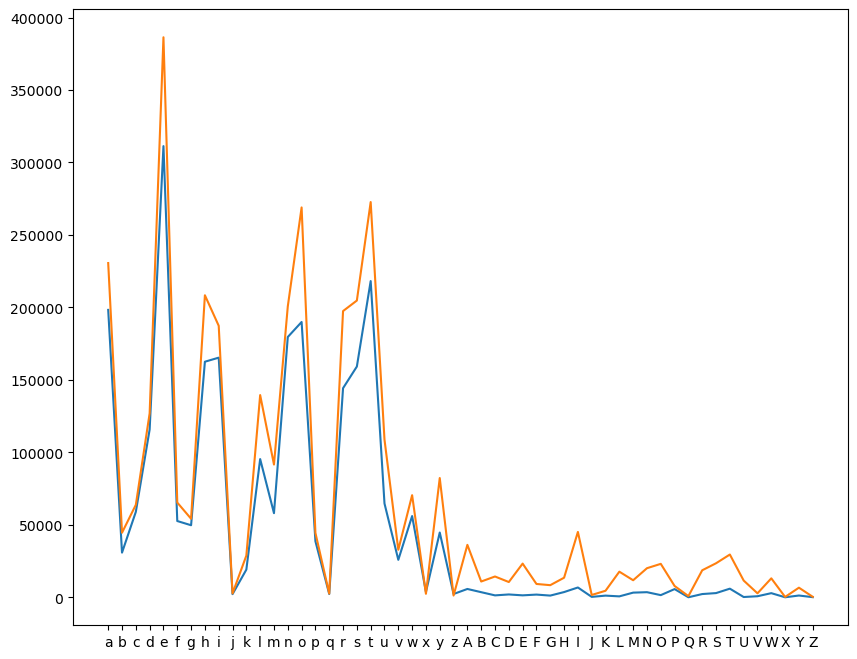

In [32]:
fr_stat = {}
fr_stat_2 = {}
chars: list[str] = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')

char_ids: list[int] = [char_to_ix[ch] for ch in chars]
n_chars: int = len(chars)
plt.plot(range(n_chars), fr[char_ids], label="War&Peace")

char_ids2: list[int] = [char_to_ix_2[ch] for ch in chars]
plt.plot(range(n_chars), fr_2[char_ids2], label="Shakespeare")

plt.xticks(range(n_chars), chars)

plt.show()

## Text encryption

To investigate this problem, Marc tried the algorithm out on a problem to which he knew the answer. First of all he encrypted the piece of Shakespeare’s Hamlet.

**Task 3.** Write a function *generate_random_permutation_map* that generates a random permutation map for given character list without digits.

In [33]:
def az_list():
    """
    Returns a default a-zA-Z characters list
    """
    cx = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')
    return cx

def generate_identity_p_map(chars):
    """
    Generates an identity permutation map for given list of characters

    Arguments:
    chars: list of characters

    Returns:
    p_map: an identity permutation map

    """
    p_map = {}
    for c in chars:
        p_map[c] = c

    return p_map

def generate_random_permutation_map(chars: list[str]):
    """
    Generate a random permutation map for given character list. Only allowed permutations
    are alphabetical ones.

    Arguments:
    chars: list of characters

    Returns:
    p_map: a randomly generated permutation map for each character
    """
    shuffled_order: np.ndarray = np.random.permutation(az_list())
    p_map: dict[str, str] = generate_identity_p_map(chars)
    
    for i, s in enumerate(az_list()):
        p_map[s] = shuffled_order[i]

    return p_map

In [34]:
p_map = generate_random_permutation_map(list(char_to_ix.keys()))
assert len(p_map) == 83

1. **Task 4.** Write a function *scramble_test* that scrambles a text given a permutation map.

In [35]:
def scramble_text(text, p_map):
    """
    Scrambles a text given a permutation map

    Arguments:
    text: text to scramble, list of characters

    p_map: permutation map to scramble text based upon

    Returns:
    text_2: the scrambled text
    """
    new_text = [p_map[s] for s in text]

    return new_text

In [36]:
def pretty_print(text):
    print(''.join(text[1:500]),'...')

In [37]:
s = list(open(filename_2, 'r').read()[530:1000])

t = list(s)
p_map = generate_random_permutation_map(list(char_to_ix.keys()))
p_map_reverse = {c: x for x, c in p_map.items()}
scrambled_text = scramble_text(t, p_map)
print('Original text:')
pretty_print(t)
print('\n')
print('Encrypted text:')
pretty_print(scrambled_text)

Original text:

What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.

 ...


Encrypted text:

ropS pNSoVUGSm CNULTGSC VK lVNHv UTHGTwT NC: GL SoTm
lVNHv mGTHv NC XNS SoT CNxTULHNGSm, loGHT GS lTUT
loVHTCVtT, lT tGfoS fNTCC SoTm UTHGTwTv NC oNtpKTHm;
XNS SoTm SoGKy lT pUT SVV vTpU: SoT HTpKKTCC SopS
pLLHGJSC NC, SoT VXuTJS VL VNU tGCTUm, GC pC pK
GKwTKSVUm SV xpUSGJNHpUGCT SoTGU pXNKvpKJT; VNU
CNLLTUpKJT GC p fpGK SV SoTt jTS NC UTwTKfT SoGC lGSo
VNU xGyTC, TUT lT XTJVtT UpyTC: LVU SoT fVvC yKVl h
CxTpy SoGC GK oNKfTU LVU XUTpv, KVS GK SoGUCS LVU UTwTKfT.

 ...


## Text decryption

One may associate a plausibility to $f$ via

$$Pl(f) = ∏ M(f(s_i), f(s_{i+1})),$$

where $s_i$ runs over consecutive symbols in the coded message. Functions $f$ which have high values of $Pl(f)$ are good candidates for decryption. Maximizing $f$ were searched for by running the following Markov chain Monte Carlo algorithm:



*   Start with a preliminary guess, say $f$;
*   Compute $Pl(f)$;
*   Change to $f_∗$ by making a random transposition of the values $f$ assigns to two symbols;
*   Compute $Pl(f_∗)$; if this is larger than $Pl(f)$, accept $f_∗$;
*   If not, flip a $Pl(f_∗)/Pl(f)$ coin; if it comes up heads, accept $f_∗$;
*   If the coin toss comes up tails, stay at $f$.

**Task 5.** Write a function *compute_transition_counts* that computes transition counts for a given text and mapping of letters to indices.

In [38]:
def compute_transition_counts(text, char_to_ix):
    """
    Computes transition counts for a given text

    Arguments:
    text: Text as a list of characters

    char_to_ix: character to index mapping

    Returns:
    transition_counts: transition_counts[i, j] gives number of times character j follows i
    """

    N_symbols = len(char_to_ix)
    transition_matrix: np.ndarray = np.zeros((N_symbols, N_symbols))
    
    for i in range(len(text)-1):
        s, next_s = text[i], text[i+1]
        transition_matrix[char_to_ix[s], char_to_ix[next_s]] += 1

    return transition_matrix

In [39]:
transtion_counts = compute_transition_counts(scrambled_text, char_to_ix)
assert transtion_counts.shape[0] == len(char_to_ix)
assert np.sum(transtion_counts) == len(scrambled_text)-1

In [40]:
def compute_log_probability_by_counts(transition_counts, text, permutation_map, char_to_ix, frequency_statistics, transition_matrix):
    """
    Computes the log probability of a text under a given permutation map (switching the
    character c from permutation_map[c]), given the transition counts and the text

    Arguments:

    transition_counts: a matrix such that transition_counts[i, j] gives the counts of times j follows i

    text: text to compute probability of, should be list of characters

    permutation_map[c]: gives the character to replace 'c' by

    char_to_ix: characters to index mapping

    frequency_statistics: frequency of character i is stored in frequency_statistics[i]

    transition_matrix: probability of j following i stored at [i, j] in this matrix

    Returns:

    p: log likelihood of the given text
    """
    c0 = char_to_ix[permutation_map[text[0]]]
    p = np.log(frequency_statistics[c0])

    p_map_indices = {}
    for c1, c2 in permutation_map.items():
        p_map_indices[char_to_ix[c1]] = char_to_ix[c2]

    indices = [value for (key, value) in sorted(p_map_indices.items())]
    p += np.sum(transition_counts*np.log(transition_matrix[indices,:][:, indices] + 1e-6))

    return p

In [41]:
p2 = compute_log_probability_by_counts(transtion_counts, scrambled_text, p_map, char_to_ix, fr, tr)
p2

-4523.414162017499

In [42]:
def get_state(text, transition_matrix, frequency_statistics, char_to_ix):
    """
    Generates a default state of given text statistics

    Returns:
    state: A state that can be used along with,
           compute_probability_of_state, propose_a_move,
           and pretty_state for metropolis_hastings

    """
    transition_counts = compute_transition_counts(text, char_to_ix)
    p_map = generate_identity_p_map(char_to_ix.keys())

    state = {"text" : text, "transition_matrix" : transition_matrix,
             "frequency_statistics" : frequency_statistics, "char_to_ix" : char_to_ix,
            "permutation_map" : p_map, "transition_counts" : transition_counts}

    return state

def compute_probability_of_state(state):
    """
    Computes the probability of given state using compute_log_probability_by_counts
    """

    p = compute_log_probability_by_counts(state["transition_counts"], state["text"], state["permutation_map"],
                                          state["char_to_ix"], state["frequency_statistics"], state["transition_matrix"])

    return p

def move_one_step(p_map):
    """
    Swaps two characters in the given p_map

    Return:
    p_map_2: new p_map, after swapping the characters
    """

    keys = az_list()
    sample = random.sample(keys, 2)

    p_map_2 = deepcopy(p_map)
    p_map_2[sample[1]] = p_map[sample[0]]
    p_map_2[sample[0]] = p_map[sample[1]]

    return p_map_2

def propose_a_move(state):
    """
    Proposes a new move for the given state,
    by moving one step (randomly swapping two characters)
    """
    new_state = {}
    for key, value in state.items():
        new_state[key] = value
    new_state["permutation_map"] = move_one_step(state["permutation_map"])
    return new_state

In [43]:
def pretty_string(text, full=False):
    """
    Pretty formatted string
    """
    if not full:
        return ''.join(text[1:200]) + '...'
    else:
        return ''.join(text) + '...'

def pretty_state(state, full=False):
    """
    Returns the state in a pretty format
    """
    if not full:
        return pretty_string(scramble_text(state["text"][1:200], state["permutation_map"]), full)
    else:
        return pretty_string(scramble_text(state["text"], state["permutation_map"]), full)

**Task 6.** Write a function *metropolis_hastings* that perfoms the Metropolis-Hastings (see at the beginning of the current subsection):

*   Start with a initial state (you can use *get_state* function on the scrambled text);
*   Compute *log_density* on the initial state (it can be *compute_probability_of_state* function);
*   Change to a new state by making a random transposition of the values in the current step (pay attention to the *propose_a_move* function);
*   Compute *log_density* on a new state; if this is larger than *log_density* of the current state accept new state;
*   If not, flip a difference-of-densities coin; if it comes up heads, accept new state;
*   If the coin toss comes up tails, stay at the current state.

In [44]:
def metropolis_hastings(initial_state, proposal_function, log_density, iters=100, print_every=10,
                        tolerance=0.02, error_function=None, pretty_state=None):
    """
    Runs a metropolis hastings algorithm given the settings

    Arguments:

    initial_state: state from where we should start moving

    proposal_function: proposal function for next state, it takes the current state
                       and returns the next state

    log_density: log probability(upto an unknown normalization constant) function, takes a
                 state as input, and gives the log(probability*some constant) of the state.

    iters: number of iters to continue

    print_every: print every $ iterations the current statistics. For diagnostics purposes.

    tolerance: if acceptance rate drops below this, we stop the simulation

    error_function: computes the error for current state. Printed every print_every iterations.
                    Just for your diagnostics.

    pretty_state: A function from your side to print the current state in a pretty format.

    Returns:

    states: List of states generated during simulation

    cross_entropies: list of negative log probabilites during the simulation.

    errors: lists of errors generated if given error_function, none otherwise.

    """

    p1 = log_density(initial_state)
    p1 = np.nan_to_num(p1)
    errors = []
    cross_entropies = []
    

    state = initial_state
    cnt = 0
    accept_cnt = 0
    error = -1
    states = [initial_state]
    it = 0

    while it < iters:
        new_state = proposal_function(state)
        p2 = log_density(new_state)
        cnt += 1
        
        ##YOUR CODE IS HERE: accept the new move if p2>p1 or with probability p2-p1
        if p2 > p1 or np.log(np.random.rand()) < p2 - p1:
            #YOUR CODE IS HERE: update the state
            state = new_state

            #increment the iteration counter
            it += 1

            #increment the acceptance counter
            accept_cnt += 1

            #update the current state probability
            p1 = p2

            #YOUR CODE IS HERE: append errors and states
            states.append(state)
            cross_entropies.append(p2)
            if error_function is not None:
                error = error_function(state)
                errors.append(error)

            #print if required
            if it % print_every == 0:
                acceptance = float(accept_cnt)/float(cnt)
                s = ""
                if pretty_state is not None:
                    s = "Current state : " + pretty_state(state)

                print("Entropy : ", -p1, ", Error : ", error, ", Acceptance : ", acceptance)
                print(s)
                print('\n')

                if acceptance < tolerance:
                    break

                cnt = 0
                accept_cnt = 0

    if error_function is None:
        errors = None

    return states, cross_entropies, errors

Entropy :  1146.1418233562745 , Error :  -1 , Acceptance :  0.25253800697004897
Current state : Shat authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanne...


Entropy :  1143.9601426169613 , Error :  -1 , Acceptance :  0.24952901398610122
Current state : That authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanne...


Entropy :  1149.6560559923375 , Error :  -1 , Acceptance :  0.25285728734702134
Current state : What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanne...


Entropy :  1149.2212427139016 , Error :  -1 , Acceptance :  0.2549069589599796
Current state : Ohat 

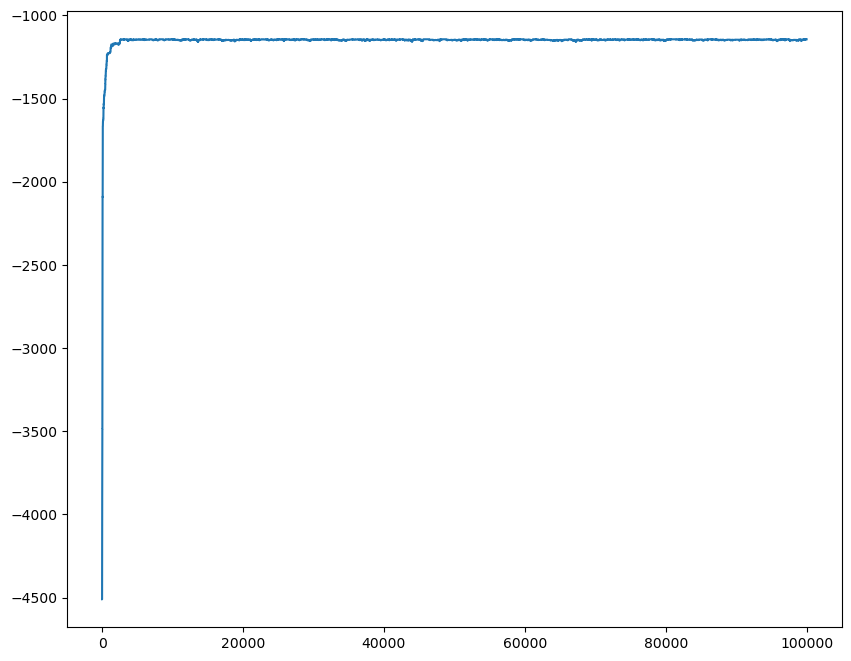

In [45]:
#time to run monte carlo
i = 0
initial_state = get_state(scrambled_text, tr, fr, char_to_ix)

while i < 1:
    state, lps, _ = metropolis_hastings(
        initial_state, 
        propose_a_move, 
        compute_probability_of_state,
        iters=100000, 
        print_every=20000, 
        tolerance=0.02, 
        pretty_state=pretty_state
    )

    plt.plot(lps)
    i += 1

plt.show()

We can compare the last state text with the original one:

In [50]:
print('Original text:')
pretty_print(state[0]["text"])
print("Resulting text:")
pretty_state(state[-1])

Original text:

ropS pNSoVUGSm CNULTGSC VK lVNHv UTHGTwT NC: GL SoTm
lVNHv mGTHv NC XNS SoT CNxTULHNGSm, loGHT GS lTUT
loVHTCVtT, lT tGfoS fNTCC SoTm UTHGTwTv NC oNtpKTHm;
XNS SoTm SoGKy lT pUT SVV vTpU: SoT HTpKKTCC SopS
pLLHGJSC NC, SoT VXuTJS VL VNU tGCTUm, GC pC pK
GKwTKSVUm SV xpUSGJNHpUGCT SoTGU pXNKvpKJT; VNU
CNLLTUpKJT GC p fpGK SV SoTt jTS NC UTwTKfT SoGC lGSo
VNU xGyTC, TUT lT XTJVtT UpyTC: LVU SoT fVvC yKVl h
CxTpy SoGC GK oNKfTU LVU XUTpv, KVS GK SoGUCS LVU UTwTKfT.

 ...
Resulting text:


'That authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanne...'

# Useful sources:

1. The material for the lab is mainly taken from the ["The Markov Chain Monte Carlo Revolution"](https://www.ams.org/journals/bull/2009-46-02/S0273-0979-08-01238-X/S0273-0979-08-01238-X.pdf)

2. [Lecture](https://youtu.be/h8MBpaTeAaQ?feature=shared) on the markov chains and MCMC (quite difficult and in Russian)